In [1]:
# Copyright 2022 NVIDIA Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

<img src="http://developer.download.nvidia.com/compute/machine-learning/frameworks/nvidia_logo.png" style="width: 90px; float: right;">

# Getting Started with NVTabular: Process Tabular Data On GPU

This notebook is created using the latest stable [merlin-tensorflow](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/merlin/containers/merlin-tensorflow/tags) container. 

## Overview

[Merlin NVTabular](https://github.com/NVIDIA-Merlin/NVTabular) is a library for processing tabular data. It lets Data Scientists and ML Engineers easily process data leveraging custom operators specifically designed for machine learning workflows. The processing is carried out on the GPU with best practices baked into the library. Running on the GPU translates to faster iteration cycles and thanks to leveraging `dask`, enables working on arbitrarily large datasets. NVTabular is a part of the [Merlin open source framework](https://developer.nvidia.com/nvidia-merlin) which allows for seamless transitioning to working with your preprocessed data using the numerous other libraries, including ones for model construction and serving.

Core features of Merlin NVTabular:
- Many different operators (`Categorify`, `FillMissing`, `TargetEncoding`, `Groupby`, etc) tailored for processing tabular data at scale
- Flexible APIs targeted to both production and research
- Deep integration with NVIDIA Merlin platform, including Merlin Models for constructing and training Deep Learning models and Merlin Systems for model serving


### Learning objectives

- Processing the Movielens dataset.
- Understanding Merlin NVTabular high-level concepts (Dataset, Workflow)
- A first look at operators and defining the preprocessing workflow

## Downloading the dataset

### MovieLens25M

The [MovieLens25M](https://grouplens.org/datasets/movielens/25m/) is a popular dataset for recommender systems and is widely used in academic publications. The dataset contains 25M movie ratings for 62,000 movies given by 162,000 users. Many projects use only the user/item/rating information of MovieLens, but the original dataset provides metadata for the movies, as well. For example, which genres a movie has.

To streamline obtaining data, we will use a function from Merlin Models.

In [2]:
import os
from merlin.datasets.entertainment import get_movielens

input_path = os.environ.get("INPUT_DATA_DIR", os.path.expanduser("~/merlin-framework/movielens/"))
get_movielens(variant="ml-1m", path=input_path);

2022-07-12 05:50:35.982606: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-12 05:50:35.983073: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-12 05:50:35.983227: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
/usr/local/lib/python3.8/dist-packages/cudf/core/frame.py:384: UserWarning: The deep parameter is ignored and is only included for pandas compatibility.
  warnings.warn(


The original dataset has been preprocessed slightly to make it easier to work with. Instead of having to deal with `dat` files, we can read files directly into `cudf` using the parquet format.

The data has already been split for us into train and validation sets.

In [3]:
ls {input_path}/ml-1m #noqa

README                    ratings.dat    users.dat
movies.dat                train.parquet  users_converted.parquet
movies_converted.parquet  transformed/   valid.parquet


For our initial workflow, let's use the `rating` and `genres` as our features.

In [4]:
import cudf

train = cudf.read_parquet(f'{input_path}/ml-1m/train.parquet')
valid = cudf.read_parquet(f'{input_path}/ml-1m/train.parquet')

movies = cudf.read_parquet(f'{input_path}/ml-1m/movies_converted.parquet')

From the provided `train` and `validation` sets we will extract `userId`, `movieId` and `rating`. Additionally, we will merge the `movies` DataFrame onto our `train` and `validation` sets using the `movieId` column as key. This will allow us to use `genres` as well.

The `genres` are represented as a list of categories, which is something our workflow can accommodate.

In [5]:
train.head()

,userId,movieId,rating,timestamp
783655,4680,2371,5,963705376
935675,5645,3499,3,959231448
926892,5602,480,3,959816541
59646,405,2915,3,976388746
721569,4318,1090,5,965378880


In [6]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Animation, Children's, Comedy]"
1,2,Jumanji (1995),"[Adventure, Children's, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama]"
4,5,Father of the Bride Part II (1995),[Comedy]


## Defining the workflow

Before we can leverage `NVTabular`, we need to convert our data to a `Merlin Dataset`.

We achieve this by passing the `cudf.DataFrame` to the `Dataset` constructor.

In [7]:
import nvtabular as nvt

train_ds = nvt.Dataset(train)
valid_ds = nvt.Dataset(valid)

train_ds, valid_ds

(<merlin.io.dataset.Dataset at 0x7ff94625cee0>,
 <merlin.io.dataset.Dataset at 0x7ff9462290d0>)

Now that we have read in our data, let's define a workflow.

A workflow consists of one or more preprocessing steps that will be applied to our data.

We begin by converting `userId` and `movieId` columns to categories. In our dataset, they are already represented as integers, but many models require them to be continuous, which is not something we can guarantee about our input data before preprocessing. Further to that, in order to train models on our data, we need to ensure we handle categories not seen in the train dataset.

We achieve both these tasks with the `Categorify` operator.

In [8]:
encoded_categories = ['userId', 'movieId'] >> nvt.ops.Categorify()

Above, we are telling `NVTabular` to select the `userId` and `movieId` columns and to apply the `Categorify` operator to them. We store the results as `encoded_categories`.

When we run the cell above, the actual operation is not performed. Only a graph representation of the operation is created.

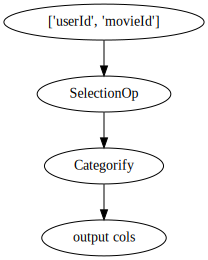

In [9]:
encoded_categories.graph

After we finish defining preprocessing steps, we combine them to create a `Workflow`. But before we do so, let's create additional preprocessing steps.

Let us now add the `genres` information from the `movies` `DataFrame`.

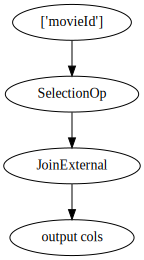

In [10]:
genres = ['movieId'] >> nvt.ops.JoinExternal(movies, on='movieId', columns_ext=['movieId', 'genres'])
genres.graph

We now combine these two operations and additionally add the `rating` column to the output.

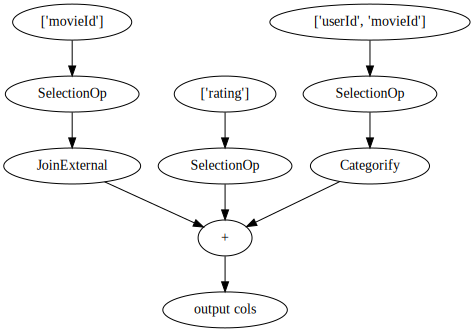

In [11]:
output = encoded_categories + genres + ['rating']
output.graph

Time to create a `Workflow`. A `Workflow` combine our preprocessing steps to create a pipeline that can be `fitted` to our data and used to transform it.

In [12]:
workflow = nvt.Workflow(output)

## Applying the workflow to the train and validation sets

`NVTabular` follows the familiar `sklearn` API. We can fit the workflow to our train set and subsequently use it to transform our validation dataset.

In [13]:
train_transformed = workflow.fit_transform(train_ds)
train_transformed.compute().head()

/usr/local/lib/python3.8/dist-packages/cudf/core/frame.py:384: UserWarning: The deep parameter is ignored and is only included for pandas compatibility.
  warnings.warn(


,userId,movieId,genres,rating
0,827,489,[Comedy],5
1,1117,280,[Horror],3
2,3516,5,"[Action, Adventure, Sci-Fi]",3
3,4344,282,[Comedy],3
4,379,148,"[Drama, War]",5


We have applied the workflow, but there is still some preprocessing that is missing.

Our genres are represented as strings. In order for our model to be able to use them, they need to be represented as integers.

Let's add another preprocessing step that will do just that.

In [14]:
encoded_genres = genres >> nvt.ops.Categorify()

We can now recreate our `Workflow` and re-fit it.

In [15]:
# ideally, this will not be here, I just added it to try things out
target_binary = ['rating'] >> nvt.ops.LambdaOp(lambda col, gdf: col > 3) >> nvt.ops.Rename(name='target_binary')

In [16]:
workflow = nvt.Workflow(encoded_categories + encoded_genres + ['rating'] + target_binary)

train_transformed = workflow.fit_transform(train_ds)
train_transformed.compute().head()

/usr/local/lib/python3.8/dist-packages/cudf/core/frame.py:384: UserWarning: The deep parameter is ignored and is only included for pandas compatibility.
  warnings.warn(


,userId,movieId,genres,rating,target_binary
0,827,489,[1],5,True
1,1117,280,[9],3,False
2,3516,5,"[3, 7, 5]",3,False
3,4344,282,[1],3,False
4,379,148,"[2, 11]",5,True


That's what we have been looking for!

We have now fitted the workflow to our training set and used it to transform it. Let us now also transform the validation set.

In [17]:
valid_transformed = workflow.transform(valid_ds)
valid_transformed.compute().head()

,userId,movieId,genres,rating,target_binary
0,827,489,[1],5,True
1,1117,280,[9],3,False
2,3516,5,"[3, 7, 5]",3,False
3,4344,282,[1],3,False
4,379,148,"[2, 11]",5,True


## Using the transformed datasets

We can export processed data to a `cudf DataFrame`.

In [18]:
gdf = train_transformed.compute()
type(gdf)

cudf.core.dataframe.DataFrame

Or we can output it to disk.

In [19]:
train_transformed.to_parquet('train_transformed')
!ls train_transformed

_file_list.txt	_metadata  _metadata.json  part_0.parquet  schema.pbtxt


Writing it out to disk not only stores the data, but also presrves the `schema` that we implicitly created during preprocessing.

In [20]:
train_transformed.schema

,name,tags,dtype,is_list,is_ragged,properties.num_buckets,properties.freq_threshold,properties.max_size,properties.start_index,properties.cat_path,properties.domain.min,properties.domain.max,properties.domain.name,properties.embedding_sizes.cardinality,properties.embedding_sizes.dimension
0,userId,(Tags.CATEGORICAL),int64,False,False,NaN,0.0,0.0,0.0,.//categories/unique.userId.parquet,0.0,6041.0,userId,6041.0,210.0
1,movieId,(Tags.CATEGORICAL),int64,False,False,NaN,0.0,0.0,0.0,.//categories/unique.movieId.parquet,0.0,3669.0,movieId,3669.0,159.0
2,genres,(Tags.CATEGORICAL),int64,True,True,NaN,0.0,0.0,0.0,.//categories/unique.genres.parquet,0.0,19.0,genres,19.0,16.0
3,rating,(),int64,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,target_binary,(),bool,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The information contained in the schema can be processed by downstream tools, such as `Merlin Models` and `Merlin Systems`, to streamline model training and deployment.

This brings us to the third option available to us.

We can use our `Dataset`s to train a model directly (or to store it to disk, read it back in as `Dataset`s, and proceed with training).

Let's finish off this notebook with training a DLRM (a Deep Learning Recommendation Model introduced in [Deep Learning Recommendation Model for Personalization and Recommendation Systems](https://arxiv.org/abs/1906.00091)) on our preprocessed data.

Thanks to the information in the schema this will require very few lines of code.

To learn more about the `NVTabular` and `Merlin Models`, please see this [example](https://github.com/NVIDIA-Merlin/models/blob/main/examples/02-Merlin-Models-and-NVTabular-integration.ipynb in the `Merlin Models` [repository](https://github.com/NVIDIA-Merlin/models).

In [ ]:
# uses default embedding_dim = 64
model = mm.Model.from_block(mm.MLPBlock([64, 32]),
    schema, prediction_tasks=mm.BinaryClassificationTask(target_column)
)

In [35]:
%%time

o = mm.sample_batch(train_transformed, 10)

In [37]:
embedding_block = mm.EmbeddingFeatures.from_schema(train_transformed.schema)

In [ ]:
mm.MLPBlock()

In [41]:
embedding_block(o[0])

{'genres': <tf.Tensor: shape=(10, 64), dtype=float32, numpy=
 array([[ 7.10194632e-02,  4.11261991e-02, -9.54716578e-02,
         -1.62769910e-02, -4.36895672e-04, -3.36638689e-02,
          1.68310367e-02, -9.47786495e-03, -9.67038870e-02,
         -4.35260125e-02, -2.66265105e-02,  8.51152986e-02,
         -5.24825044e-02, -5.62885813e-02,  2.21810210e-02,
          2.85433736e-02,  2.61958987e-02, -1.06744338e-02,
          3.96949574e-02,  2.64565833e-02, -7.19869435e-02,
          1.52420218e-03, -6.79426361e-03, -9.24140960e-02,
          4.71112654e-02,  2.27004047e-02,  5.48924645e-03,
         -1.75790098e-02,  2.39073392e-02,  2.61092689e-02,
         -6.28739074e-02, -7.30363606e-03,  3.69565263e-02,
         -4.41401154e-02, -3.93652879e-02,  5.00660110e-03,
         -8.49090237e-03, -1.88151058e-02,  7.99232721e-03,
          3.54223736e-02,  1.77062117e-02,  1.98735371e-02,
         -3.35719064e-02,  5.19448034e-02, -8.12076405e-02,
          5.34982644e-02, -6.38536885e-

In [40]:
mm.ConcatFeatures(embedding_block(o[0]))

ConcatFeatures(
  (axis): Dict(
    (genres): <tf.Tensor: shape=(10, 64), dtype=float32, numpy=
    array([[ 7.10194632e-02,  4.11261991e-02, -9.54716578e-02,
            -1.62769910e-02, -4.36895672e-04, -3.36638689e-02,
             1.68310367e-02, -9.47786495e-03, -9.67038870e-02,
            -4.35260125e-02, -2.66265105e-02,  8.51152986e-02,
            -5.24825044e-02, -5.62885813e-02,  2.21810210e-02,
             2.85433736e-02,  2.61958987e-02, -1.06744338e-02,
             3.96949574e-02,  2.64565833e-02, -7.19869435e-02,
             1.52420218e-03, -6.79426361e-03, -9.24140960e-02,
             4.71112654e-02,  2.27004047e-02,  5.48924645e-03,
            -1.75790098e-02,  2.39073392e-02,  2.61092689e-02,
            -6.28739074e-02, -7.30363606e-03,  3.69565263e-02,
            -4.41401154e-02, -3.93652879e-02,  5.00660110e-03,
            -8.49090237e-03, -1.88151058e-02,  7.99232721e-03,
             3.54223736e-02,  1.77062117e-02,  1.98735371e-02,
            -3.3571906

In [36]:
o

({'genres': (<tf.Tensor: shape=(18, 1), dtype=int64, numpy=
   array([[ 1],
          [ 9],
          [ 3],
          [ 7],
          [ 5],
          [ 1],
          [ 2],
          [11],
          [ 1],
          [ 8],
          [14],
          [ 4],
          [ 1],
          [ 1],
          [ 6],
          [ 9],
          [ 1],
          [15]])>,
   <tf.Tensor: shape=(10, 1), dtype=int32, numpy=
   array([[1],
          [1],
          [3],
          [1],
          [2],
          [4],
          [1],
          [2],
          [1],
          [2]], dtype=int32)>),
  'userId': <tf.Tensor: shape=(10, 1), dtype=int64, numpy=
  array([[ 827],
         [1117],
         [3516],
         [4344],
         [ 379],
         [2960],
         [ 959],
         [2103],
         [4964],
         [3315]])>,
  'movieId': <tf.Tensor: shape=(10, 1), dtype=int64, numpy=
  array([[ 489],
         [ 280],
         [   5],
         [ 282],
         [ 148],
         [ 172],
         [1845],
         [  63],
    

In [ ]:
batch = mm.sample_batch(valid, batch_size=5, shuffle=False, include_targets=False)
batch["userId"]

## Training a DLRM model

We define the DLRM model, whose prediction task is a binary classification. From the `schema`, the categorical features are identified (and embedded) and the target column is also automatically inferred, because of the schema tags. We talk more about the schema in the next [example notebook (02)](02-Merlin-Models-and-NVTabular-integration.ipynb),

In [21]:
import merlin.models.tf as mm

2022-07-12 05:50:38.330170: I tensorflow/core/platform/cpu_feature_guard.cc:152] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-12 05:50:38.331016: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-12 05:50:38.331217: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-12 05:50:38.331366: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning

In [31]:
model = mm.benchmark.NCFModel(
    train_transformed.schema,
    mlp_block=mm.MLPBlock([256, 64]),
    embedding_dim=64,
    prediction_tasks=mm.prediction_tasks.classification.BinaryClassificationTask(target='target_binary'),
)

ValueError: Tag: Tags.USER_ID does not uniquely identify a column

In [27]:
model = mm.DLRMModel(
    train_transformed.schema,
    embedding_dim=64,
    prediction_tasks=mm.prediction_tasks.classification.BinaryClassificationTask(target='target_binary'),
)

model.compile(optimizer="adam")

In [28]:
model.fit()

ValueError: Failed to find data adapter that can handle input: <class 'NoneType'>, <class 'NoneType'>

In [40]:
model = mm.DLRMModel(
    train_transformed.schema,
    embedding_dim=64,
    bottom_block=mm.MLPBlock([128, 64]),
    top_block=mm.MLPBlock([128, 64, 32]),
    prediction_tasks=mm.prediction_tasks.regression.RegressionTask(target='rating'),
)

model.compile(optimizer="adam")

In [24]:
train_transformed.schema

,name,tags,dtype,is_list,is_ragged,properties.num_buckets,properties.freq_threshold,properties.max_size,properties.start_index,properties.cat_path,properties.domain.min,properties.domain.max,properties.domain.name,properties.embedding_sizes.cardinality,properties.embedding_sizes.dimension
0,userId,(Tags.CATEGORICAL),int64,False,False,NaN,0.0,0.0,0.0,.//categories/unique.userId.parquet,0.0,6041.0,userId,6041.0,210.0
1,movieId,(Tags.CATEGORICAL),int64,False,False,NaN,0.0,0.0,0.0,.//categories/unique.movieId.parquet,0.0,3669.0,movieId,3669.0,159.0
2,genres,(Tags.CATEGORICAL),int64,True,True,NaN,0.0,0.0,0.0,.//categories/unique.genres.parquet,0.0,19.0,genres,19.0,16.0
3,rating,(),int64,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
model.fit(train_transformed, batch_size=1024)

ValueError: in user code:

    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.8/dist-packages/merlin/models/tf/models/base.py", line 463, in train_step
        self._validate_target_and_loss(outputs.targets, loss)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 818, in _validate_target_and_loss
        raise ValueError(

    ValueError: Target data is missing. Your model was compiled with loss={'rating/regression_task': <keras.losses.MeanSquaredError object at 0x7f1ac74450d0>}, and therefore expects target data to be provided in `fit()`.


We evaluate the model...

In [6]:
metrics = model.evaluate(valid, batch_size=1024, return_dict=True)

2022-05-03 09:41:02.880315: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_19


196/196 [==============================] - 2s 5ms/step - rating_binary/binary_classification_task/precision: 0.7409 - rating_binary/binary_classification_task/recall: 0.8057 - rating_binary/binary_classification_task/binary_accuracy: 0.7264 - rating_binary/binary_classification_task/auc: 0.7936 - loss: 0.5384 - regularization_loss: 0.0000e+00 - total_loss: 0.5384


... and check the evaluation metrics. We use by default typical binary classification metrics -- Precision, Recall, Accuracy and AUC. But you can also provide your own metrics list by setting `BinaryClassificationTask(..., metrics=[])`.

In [7]:
metrics

{'rating_binary/binary_classification_task/precision': 0.7408556938171387,
 'rating_binary/binary_classification_task/recall': 0.8057063221931458,
 'rating_binary/binary_classification_task/binary_accuracy': 0.7263810634613037,
 'rating_binary/binary_classification_task/auc': 0.7936474680900574,
 'loss': 0.5632060170173645,
 'regularization_loss': 0.0,
 'total_loss': 0.5632060170173645}

## Conclusion

Merlin Models enables users to define and train a deep learning recommeder model with only 3 commands.

```python
model = mm.DLRMModel(
    train.schema,
    embedding_dim=64,
    bottom_block=mm.MLPBlock([128, 64]),
    top_block=mm.MLPBlock([128, 64, 32]),
    prediction_tasks=mm.BinaryClassificationTask(
        train.schema.select_by_tag(Tags.TARGET).column_names[0]
    ),
)
model.compile(optimizer="adam")
model.fit(train, batch_size=1024)
```

## Next steps

In the next example notebooks, we will show how the integration with NVTabular and how to explore different recommender models.